### Логистическая регресcия над градиентным бустингом с AdaBoost loss

#### Decision tree regressor

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import copy

In [2]:
EPSILON = 1e-5

class OldTree:
    def __init__(self, depth):
        self.depth = depth
        
        
    def score_split(self, l_c, r_c, l_s, r_s):
        return - (l_c*(l_s ** 2) + r_c*(r_s ** 2)) / (l_c+r_c)
            
    
    def find_split(self, x, y):
        rss = np.zeros(self.n_features)
        split_vals = np.zeros(self.n_features)
        
        for feature in range(self.n_features):
            scores = np.zeros(len(x))
            
            sorted_x_idx = np.argsort(x[:, feature])
            
            x_ = x[sorted_x_idx]
            y_ = y[sorted_x_idx]

            l_c = 0
            r_c = len(x_)
            
            l_s = 0
            r_s = np.sum(y_)
            
            for i in range(len(x_)):
                l_c += 1
                r_c -= 1
                
                l_s += y_[i]
                r_s -= y_[i]

                if l_c < 1 or r_c < 1:
                    scores[i] = np.inf
                    continue
                                
                scores[i] = self.score_split(l_c, r_c, l_s, r_s)
            
            rss[feature] = np.min(scores)
            split_vals[feature] = x_[np.argmin(scores),feature]
            
            
            
        for i in range(len(rss)):
            split, feature = split_vals[np.argmin(rss)], np.argmin(rss)
            
            if np.sum(x[:, feature] < split) == 0:
                rss[feature] = np.inf
                continue
                
            if np.sum(x[:, feature] >= split) == 0:
                rss[feature] = np.inf
                continue
        
            return np.min(rss), split, feature
                
        return None, None, None
        
    def fit(self, x, y):
        if self.depth == 0:
            self.value = np.mean(y)
        else:
            self.n_features = x.shape[1]
            _, self.split, self.feature = self.find_split(x, y)
            
            if _ is None:
                self.depth = 0
                self.value = np.mean(y)
                return
            
            left_indicies = x[:, self.feature] < self.split
            
            if left_indicies.sum() >= 2:
                self.left = Tree(self.depth-1)
                self.left.fit(x[left_indicies], y[left_indicies])
            else:
                self.left = Tree(0)
                self.left.fit(x[left_indicies], y[left_indicies])

            
            right_indicies = x[:, self.feature] >= self.split

            if right_indicies.sum() >= 2:
                self.right = Tree(self.depth-1)
                self.right.fit(x[right_indicies], y[right_indicies])
            else:
                self.right = Tree(0)
                self.right.fit(x[right_indicies], y[right_indicies])
        
        
    def predict(self, x, get_id = True):
        out = np.zeros(len(x))
        
        if self.depth == 0:
            if get_id:
                if not hasattr(self, 'id'):
                    raise 
                return self.id
            else:
                return self.value
        else:
            out[x[:, self.feature] < self.split] = self.left.predict(x[x[:, self.feature] < self.split])
            out[x[:, self.feature] >= self.split] = self.right.predict(x[x[:, self.feature] >= self.split])
            
        return out

In [3]:
EPSILON = 1e-5

class Tree:
    def __init__(self, depth, scorer='mse'):
        self.depth = depth
        self.scorer = scorer
        
        
    def score_split(self, left_x, right_x, left_y, right_y):
        if self.scorer == 'mse':
            return ((left_y - np.mean(left_y)) ** 2).sum() + ((right_y - np.mean(right_y)) ** 2).sum() 
        if self.scorer == 'impurity':
            return - (len(left_x)*sum(left_y) ** 2 + len(right_x)*sum(right_y) ** 2) / (len(left_x)+len(right_x))
        if self.scorer == 'friedman_mse':
            return -(len(left_x)*len(right_x) / (len(left_x)+len(right_x)))*(np.mean(left_y) - np.mean(right_y))**2
            
    
    def find_split(self, x, y):
        rss = np.zeros(self.n_features)
        split_vals = np.zeros(self.n_features)
        
        for feature in range(self.n_features):
            
            if len(x) > 100:
                unique = np.linspace(x.min()+EPSILON, x.max()-EPSILON, 30)
            else:
                unique = np.unique(x[:, feature])
                unique = np.sort(unique)
            
            if len(unique) == 1:
                rss[feature] = np.inf
                continue
                
            unique = (unique[1:] + unique[:-1])/2
            
            scores = np.zeros(len(unique))
            
            for i, unique_val in enumerate(unique):
                left_indicies = x[:, feature] < unique_val
                right_indicies = x[:, feature] >= unique_val
                
                scores[i] += self.score_split(x[left_indicies], x[right_indicies],
                                              y[left_indicies], y[right_indicies])
            
            rss[feature] = np.min(scores)
            split_vals[feature] = unique[np.argmin(scores)]
        
        return np.min(rss), split_vals[np.argmin(rss)], np.argmin(rss)
        
    def fit(self, x, y):
        if self.depth == 0:
            if len(y) == 0:
                self.value = 0
            else:
                self.value = np.mean(y)
        else:
            self.n_features = x.shape[1]
            _, self.split, self.feature = self.find_split(x, y)
            
            
            left_indicies = x[:, self.feature] < self.split
            
            if left_indicies.sum() >= 2:
                self.left = Tree(self.depth-1)
                self.left.fit(x[left_indicies], y[left_indicies])
            else:
                self.left = Tree(0)
                self.left.fit(x[left_indicies], y[left_indicies])

            
            right_indicies = x[:, self.feature] >= self.split

            if right_indicies.sum() >= 2:
                self.right = Tree(self.depth-1)
                self.right.fit(x[right_indicies], y[right_indicies])
            else:
                self.right = Tree(0)
                self.right.fit(x[right_indicies], y[right_indicies])
        
        
    def predict(self, x, get_id = False):
        out = np.zeros(len(x))
        
        if self.depth == 0:
            if get_id:
                if not hasattr(self, 'id'):
                    raise 
                return self.id
            else:
                return self.value
        else:
            out[x[:, self.feature] < self.split] = self.left.predict(x[x[:, self.feature] < self.split], get_id)
            out[x[:, self.feature] >= self.split] = self.right.predict(x[x[:, self.feature] >= self.split], get_id)
            
        return out

In [4]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [5]:
%time

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


DecisionTreeRegressor(max_depth=5)

In [6]:
%time

regr_3 = Tree(depth=2, scorer='friedman_mse')
regr_3.fit(X, y)

regr_4 = Tree(depth=5, scorer='friedman_mse')
regr_4.fit(X, y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


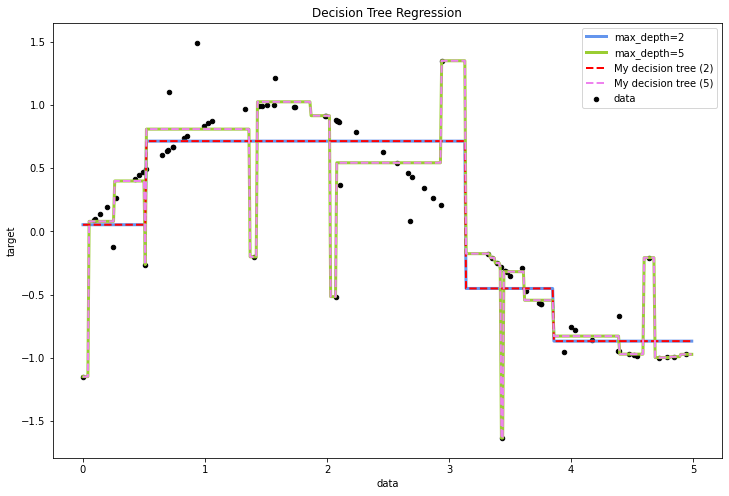

In [7]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
y_4 = regr_4.predict(X_test)


plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, c="black", label="data")

plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=3)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=3)
plt.plot(X_test, y_3, color="red", label="My decision tree (2)", linewidth=2, linestyle='dashed')

plt.plot(X_test, y_4, color="violet", label="My decision tree (5)", linewidth=2, linestyle='dashed')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

#### Gradient boosting

$$r_{i} = -\frac{\partial L(y_i, h(x_i))}{\partial h(x_i)} = -\frac{\partial exp(-y_i h(x_i)}{\partial h(x)} = exp(-y_i h(x_i) y_i = L(y_i, h(x_i))*y_i$$

$$\frac{\partial^2 L(y_i, h(x_i))}{\partial h(x_i)^2} = \frac{\partial^2 exp(-y_i h(x_i)}{\partial h(x)^2}$$

In [8]:
class GradientBoosting:
    def __init__(self, n_trees, depth, lr, steps = 10):
        self.n_trees = n_trees
        self.depth = depth
        self.lr = lr
        self.steps = steps
        
    def compute_grad(self, x, y):
        return self._compute_loss_vector(x, y) * y
    
    def _compute_loss_vector(self, x, y):
        preds = self.predict(x)
        return np.exp(-y*preds)
    
    def compute_loss(self, x, y):
        return np.mean(self._compute_loss_vector(x, y))
    
    def fit_last_tree(self, x, y):
        history = []
        last_tree_preds = self.trees[-1][0].predict(x)
        
        all_wo_last_preds = np.zeros(len(x))
        all_wo_last_preds += self.constant
        
        for tree, weight in self.trees[:-1]:
            all_wo_last_preds += self.lr*weight*tree.predict(x)

        
        for i in range(self.steps):            
            grad = np.mean(
                last_tree_preds*y*np.exp(-y*(all_wo_last_preds + self.trees[-1][1]*last_tree_preds))
            )
            
            hessian = np.mean(last_tree_preds**2*np.exp(-y*(all_wo_last_preds + self.trees[-1][1]*last_tree_preds)))
            
            if np.abs(grad) < 0.001: break
                
            history.append(self.trees[-1][1])
            self.trees[-1][1] += grad/hessian
            
        return history
        
    def fit(self, x, y, eval_X, eval_y):
        self.trees = []
        self.constant = np.mean(y)
        
        t = trange(self.n_trees)
        for tree_idx in t:
            to_predict = self.compute_grad(x, y)
            
            tree = Tree(self.depth, scorer='friedman_mse')
            tree.fit(x, to_predict)
            
            
            starting_weight = 1
            self.trees.append([tree, starting_weight])
            
            history = self.fit_last_tree(x, y)
            t.set_description(f'{self.compute_loss(x, y):.2f} / {self.compute_loss(eval_X, eval_y):.2f}')
            
            
            if tree_idx % 10 == -1:
            
                plt.figure(figsize=(7,5))
                plt.subplot(131)
                plt.plot(x,y, 'o')
                plt.plot(np.linspace(x.min(), x.max(), 100), 
                         self.predict_proba(np.linspace(x.min(), x.max(), 100).reshape([100, 1])))
                plt.title("Scatter plot of x vs. y")
                plt.xlabel("x")
                plt.ylabel("y")
                
                plt.subplot(132)
                plt.plot(x, to_predict)
                plt.plot(x, self.trees[-1][0].predict(x))
                
                plt.subplot(133)
                plt.plot(history)
                plt.show()
                
            
    def predict(self, x):
        y_hat = np.zeros(len(x))
        
        y_hat += self.constant
        
        for tree, weight in self.trees:
            y_hat += self.lr*weight*tree.predict(x)
            
        return y_hat
    
    def predict_proba(self, x):
        exp = np.exp(-self.predict(x))
        return 1/(1+exp)

In [9]:
gb = GradientBoosting(50, 2, 0.1, 10000)

In [10]:
x = np.linspace(0,10, 50).reshape([50, 1])
y = (np.sin(x)[:,0]+1)/2

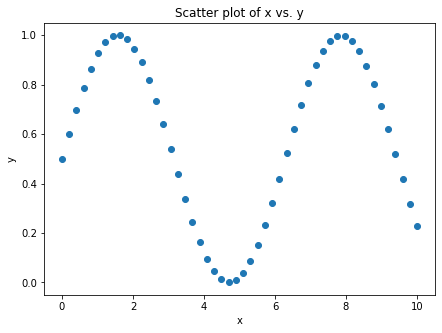

In [11]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [12]:
gb.fit(x, y, x, y)

In [13]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

X, y = make_moons(noise=0.3, random_state=0)
y = 2*y-1

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

h = .02

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

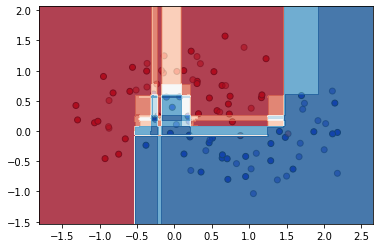

In [15]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(111)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

clf = GradientBoosting(150, 3, 0.1, 1000)
clf.fit(X_train, y_train, X_test, y_test)

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = (Z.reshape(xx.shape)+1)/2
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#### Тестирование градиентного бустинга

In [16]:
test = np.loadtxt('spam.test.txt')
train = np.loadtxt('spam.train.txt')

In [17]:
y_train = train[:, 0]
X_train = train[:, 1:]

y_test = test[:, 0]
X_test = test[:, 1:]

y_train -= 0.5
y_train *= 2

y_test -= 0.5
y_test *= 2

In [18]:
clf = GradientBoosting(15, 3, 0.1, 10000)
clf.fit(X_train, y_train, eval_X = X_test, eval_y = y_test)

/Users/daniilboiko/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daniilboiko/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

losses = {
    'train_sk':[],
    'train':[],
    'test_sk':[],
    'test':[]
}

trees_list = [1, 5, 10, 15]

for n_trees in tqdm(trees_list):
    sk_clf = GradientBoostingClassifier(loss='exponential', learning_rate= 0.1, 
                                    n_estimators=n_trees, max_depth=3)
    sk_clf.fit(X_train, y_train)
    
    clf_preds_test = np.zeros(len(X_test))
    clf_preds_test += clf.constant
    for tree, weight in clf.trees[:n_trees]:
        clf_preds_test += weight*tree.predict(X_test)*clf.lr

    clf_preds_train = np.zeros(len(X_train))
    clf_preds_train += clf.constant
    for tree, weight in clf.trees[:n_trees]:
        clf_preds_train += weight*tree.predict(X_train)*clf.lr


    losses['test'].append(np.mean(np.exp(-y_test*clf_preds_test)))
    losses['test_sk'].append(np.mean(np.exp(-y_test*sk_clf.decision_function(X_test))))
    
    losses['train'].append(np.mean(np.exp(-y_train*clf_preds_train)))
    losses['train_sk'].append(np.mean(np.exp(-y_train*sk_clf.decision_function(X_train))))

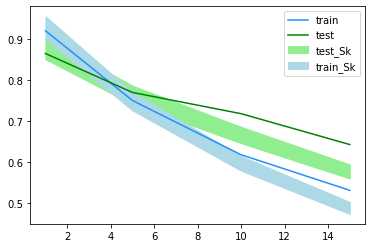

In [20]:
plt.plot(trees_list, losses['train'], color='dodgerblue', label='train')

plt.plot(trees_list, losses['test'], color='green', label='test')

plt.fill_between(trees_list,
                 np.array(losses['test_sk'])*0.97,
                 np.array(losses['test_sk'])*1.03, color='lightgreen', label='test_Sk')

plt.fill_between(trees_list,
                 np.array(losses['train_sk'])*0.97,
                 np.array(losses['train_sk'])*1.03, color='lightblue', label='train_Sk')
plt.legend()

Text(0, 0.5, 'Mine')

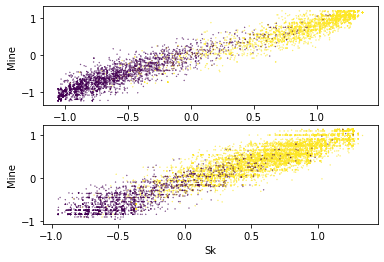

In [21]:
plt.subplot(211)
plt.scatter(sk_clf.decision_function(X_train), clf.predict(X_train), s=0.1, c=y_train)
plt.xlabel('Sk')
plt.ylabel('Mine')

plt.subplot(212)
plt.scatter(sk_clf.decision_function(X_test), clf.predict(X_test), s=0.1, c=y_test)
plt.xlabel('Sk')
plt.ylabel('Mine')

#### Извлечение признаков и логистическая регрессия

In [22]:
def enumerate_tree(tree, offset = 0):
    if tree.depth==0:
        tree.id = offset
        return offset+1
    
    else:
        offset_left = enumerate_tree(tree.left, offset)
        offset_right = enumerate_tree(tree.right, offset_left)
        
        return offset_right

In [23]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.tree_offsets = [enumerate_tree(tree) for tree, weight in model.trees]
        self.feature_vector_size = sum(self.tree_offsets)
        
    def predict(self, x):
        output = np.zeros((len(x), self.feature_vector_size))
        
        cum_offset = 0
        for (tree, weight), tree_offset in zip(self.model.trees, self.tree_offsets):
            predictions = tree.predict(x, get_id = True)
            output[np.arange(len(output)), (predictions+cum_offset).astype(int)] = 1
            
            cum_offset += tree_offset
        
        return output

In [24]:
fe = FeatureExtractor(clf)

In [25]:
X_train_transformed = fe.predict(X_train)
X_test_transformed = fe.predict(X_test)

In [26]:
def sigmoid(x):
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x

def batch_generator(X, y, shuffle=True, batch_size=1):
    n = X.shape[0]
    assert n == y.shape[0]
    
    indicies = np.arange(len(X))

    if shuffle:
        np.random.shuffle(indicies)
        
    for i in range(0,n,batch_size):
        X_batch = X[indicies[i:min(n,i+batch_size)]]
        y_batch = y[indicies[i:min(n,i+batch_size)]]
        yield (X_batch, y_batch)

class LinearRegression:

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, batch_size=10):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.batch_size = batch_size

    def calc_loss(self, X_batch, y_batch):
        predicted = self.predict(X_batch)
        
        a = sigmoid(np.dot(X_batch, self.weights))

        loss = -(1 / X_batch.shape[0]) * \
            np.sum(y_batch * np.log2(a) +
                   (1 - y_batch) * np.log2(1 - a))

        R = np.linalg.norm(self.weights) / self.C
        return loss + R

    def calc_loss_grad(self, X_batch, y_batch):
        N = X_batch.shape[0]

        a = sigmoid(np.dot(X_batch, self.weights))
        loss_grad = (1 / N) * np.dot((a - y_batch), X_batch) + \
                    (2 / self.C) * self.weights

        return loss_grad

    def update_weights(self, new_grad):
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.random.uniform(0, 1, X.shape[1])

        for n in trange(0, self.max_epoch):
            new_epoch_generator = \
                self.batch_generator(X, y,
                                     shuffle=True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)

                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

    def predict(self, X):
        y_hat = np.dot(X, self.weights)
        return (y_hat >= 0.5).astype(int)
    
    def predict_proba(self, X):
        y_hat = np.dot(X, self.weights)
        return y_hat

In [27]:
lr = LinearRegression(batch_generator, alpha=1e-2, batch_size=200)

In [28]:
lr.fit(X_train_transformed,(y_train+1)/2)

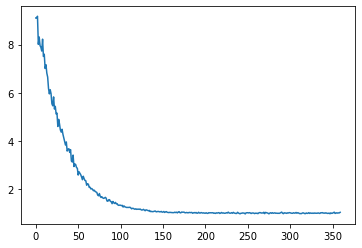

In [29]:
plt.plot(lr.errors_log['loss'])

In [30]:
X_test_transformed = np.hstack((np.ones((X_test_transformed.shape[0], 1)), X_test_transformed))

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, lr.predict_proba(X_test_transformed))

0.9578047532919837

In [32]:
roc_auc_score(y_test, clf.predict(X_test))

0.9615344387100565

In [33]:
roc_auc_score(y_test, sk_clf.predict(X_test))

0.9013602616530599